In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import gridspec
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import signal
import random
import itertools

import pandas as pd
import xarray as xr
import numpy as np
import pickle

import warnings
from tqdm import tqdm
import os

from datetime import datetime

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from data_treatment_tools import *

import pickle as pkl

In [2]:
# import matplotlib.pyplot as plt

# from tueplots import bundles

# bundles.icml2022()
# {'text.usetex': True, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}

# bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
# {'text.usetex': False, 'font.serif': ['Times'], 'mathtext.fontset': 'stix', 'mathtext.rm': 'Times', 'mathtext.it': 'Times:italic', 'mathtext.bf': 'Times:bold', 'font.family': 'sans-serif', 'figure.figsize': (6.75, 8.343458848123582), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}


# # Plug any of those into either the rcParams or into an rc_context:

# plt.rcParams.update(bundles.icml2022())

# Loading data

In [3]:
file_name = 'CMIP6_coarse5.pkl'
directory = '../data/historical/'

with open(directory + file_name, 'rb') as handle:
    data = pkl.load(handle)

In [4]:
time = np.load(directory + 'times.npy', allow_pickle=True)
lon = np.load(directory + 'lons.npy', allow_pickle=True)
lat = np.load(directory + 'lats.npy', allow_pickle=True)

In [5]:
# Parameters of DIV, RMT and RIV
n_lat, n_lon, window_size = len(lat), len(lon), 10
full_data = {}
# Adding ensemble average of tas (ea_tas) and global mean temperature (gmt)
for model in tqdm(data.keys()) :
    full_data[model] = {}
    # data[model]['ea_tas'] = data[model]['tas'].mean(axis=0)
    # data[model]['gmt'] = data[model]['ea_tas'].mean(axis=(1, 2))
    tas = data[model]
    data[model] = None
    ea_tas = np.array([tas.mean(axis=0) for i in range(tas.shape[0])])
    iv = tas - ea_tas
    full_data[model]['tas'] = tas
    full_data[model]['ea_tas'] = ea_tas
    full_data[model]['iv'] = iv
    full_data[model]['div'] = np.array([np.convolve(int_var.mean(axis=(1, 2)), np.ones(12*10)/120, mode='same') for int_var in iv])
del data

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


In [7]:
# Selecting low DIV for train and high DIV for test
models_train_full = ['ACCESS-ESM1-5', 'NorCPM1', 'CESM2', 'CanESM5']
models_test = ['CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR']
models = models_train_full + models_test

# Data analysis

In [9]:
div_std_train = []
for model in models_train_full:
    for div_std in full_data[model]['div'].std(axis=(1)) :
        div_std_train.append(div_std)
div_std_train = np.array(div_std_train)

div_std_test = []
for model in models_test:
    for div_std in full_data[model]['div'].std(axis=(1)) :
        div_std_test.append(div_std)
div_std_test = np.array(div_std_test)

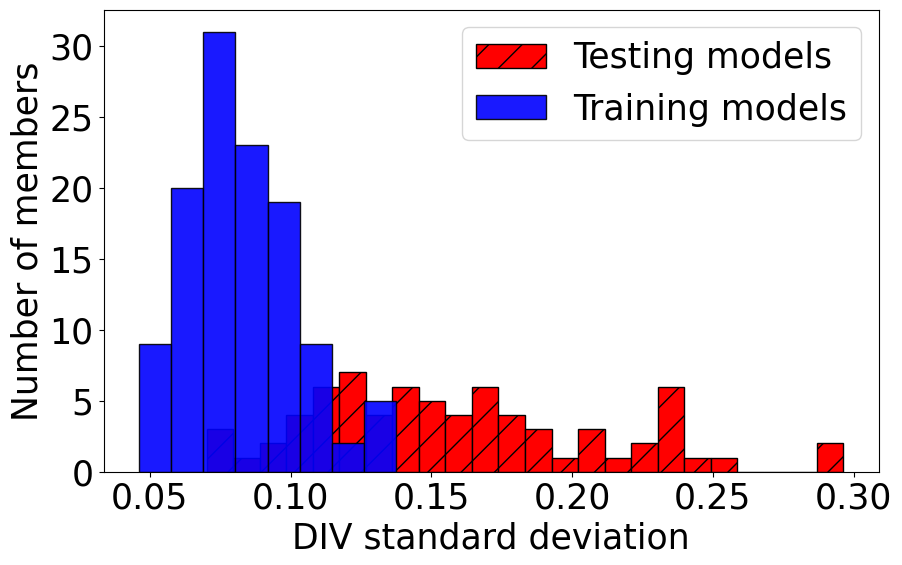

In [10]:
import matplotlib.pyplot as plt

# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(div_std_test, color='red', bins=24, edgecolor="black", label='Testing models', hatch='/')
plt.hist(div_std_train, bins=8, alpha=0.9, color='blue', edgecolor="black", label='Training models')

# Set labels and legend
plt.ylabel('Number of members', fontsize=25)
plt.xlabel('DIV standard deviation', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

# Increase the size of ticks
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Save and display the plot
directory = '../results'
plt.savefig(directory + "/DIV_train_test_split.pdf", format="pdf", bbox_inches="tight")
plt.show()



## Local trends

In [ ]:
years = 40
regional_trends = {}
for model in models:
    shape = data[model]['rmt'].shape
    Y = data[model]['rmt'][-years:,:,:].reshape(years, shape[1]*shape[2])
    X = np.arange(Y.shape[0])[:,None]
    trend = LinearRegression().fit(X, Y).coef_.reshape(shape[1], shape[2])
    regional_trends[model] = np.array(trend)

In [ ]:
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

contour = ax.pcolormesh(lon, lat, regional_trends[models[0]], transform=ccrs.PlateCarree(), cmap='coolwarm')

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.colorbar(contour, ax=ax, label='Error')

plt.title('Mean Error of ML Model on Temperature Predictions')
plt.show()


## Variability differences across training and testing models

In [ ]:
var_train = []
for model in models_train_full:
    var_train.append(data[model]['riv'].std(axis=1).mean(axis=0))
var_train_mean = np.mean(var_train, axis=0)
     
var_test = []
for model in models_test:
    var_test.append(data[model]['riv'].std(axis=1).mean(axis=0))
var_test_mean = np.mean(var_test, axis=0)

In [ ]:
diff_var = var_test_mean - var_train_mean

In [ ]:
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

contour = ax.pcolormesh(lon, lat, diff_var, transform=ccrs.PlateCarree(), cmap='coolwarm', vmax=0.3)

# Add coastlines and gridlines
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.colorbar(contour, ax=ax, label='Var(test) - Var(train)')

#plt.title('Mean Error of ML Model on Temperature Predictions')
directory = '../results'
plt.savefig(directory + "/Variability_differences_train_test_split.pdf", format="pdf", bbox_inches="tight")
plt.show()
